In [1]:
import torch
import umap
import matplotlib.pyplot as plt
from cellshape_cloud import CloudAutoEncoder
import cellshape_cloud as cloud
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import pandas as pd
import napari

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Get the name of the GPU
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No GPU available"

print("CUDA available:", cuda_available)
print("GPU Name:", gpu_name)

CUDA available: True
GPU Name: NVIDIA GeForce RTX 3090


In [2]:
from tifffile import imread
from skimage.measure import marching_cubes

membrane_dir = 'D:/Ziwei/Mari_Second_Dataset_Analysis/seg_membrane_timelapses/timelapse_second_dataset_261.tif'
membrane_seg = imread(membrane_dir)
vertices, faces, normals, values = marching_cubes(membrane_seg)



In [4]:
import cellshape_helper as helper

cloud_dataset_dir = '2nd_Dataset_last_frame/'
real_mask_dir = '2nd_Dataset_last_frame/seg_membrane_timelapses/'
num_points = 2048
min_size = (5,16,16)
helper.label_tif_to_pc_directory(real_mask_dir, cloud_dataset_dir,num_points, min_size = min_size)


100%|██████████| 1/1 [07:15<00:00, 435.85s/it]


## read model

In [10]:
from torch import nn
from cellshape_cluster.clustering_layer import ClusteringLayer

# key diff is using autoencoder.network.encoder
class DeepEmbeddedClustering(nn.Module):
    def __init__(self, autoencoder, num_clusters):
        super(DeepEmbeddedClustering, self).__init__()
        self.autoencoder = autoencoder
        self.num_clusters = num_clusters
        self.clustering_layer = ClusteringLayer(
            num_features=self.autoencoder.network.encoder.num_features,
            num_clusters=self.num_clusters,
        )

    def forward(self, x):
        features = self.autoencoder.network.encoder(x)
        clusters = self.clustering_layer(features)
        output = self.autoencoder.network.decoder(features)  # Update this line
        return output, features, clusters


In [11]:
from cellshape_cloud import CloudAutoEncoder
from kapoorlabs_lightning.pytorch_losses import ChamferLoss
from kapoorlabs_lightning.optimizers import Adam
from napatrackmater import load_json
from kapoorlabs_lightning.lightning_trainer import AutoLightningModel



model_path = 'MembraneCloud/xenopus_membrane_autoencoder.ckpt'
model_path_json = 'MembraneCloud/xenopus_membrane_autoencoder.json'

loss = ChamferLoss()
optimizer = Adam(lr=0.001)
modelconfig = load_json(model_path_json)
cloud_autoencoder = CloudAutoEncoder(
                                    num_features=modelconfig["num_features"],
                                    k=modelconfig["k_nearest_neighbours"],
                                    encoder_type=modelconfig["encoder_type"],
                                    decoder_type=modelconfig["decoder_type"],
                                    )
autoencoder = AutoLightningModel.load_from_checkpoint(model_path, network = cloud_autoencoder, 
                                                      loss_func = loss, optim_func = optimizer)

cluster_model = DeepEmbeddedClustering(
    autoencoder=autoencoder,
    num_clusters=2,
)

In [12]:
from torch.utils.data import Dataset
from pyntcloud import PyntCloud
from pathlib import Path

class PointCloudDataset(Dataset):
    def __init__(self, points_dir, centre=True, scale=20.0):
        self.points_dir = points_dir
        self.centre = centre
        self.scale = scale
        self.p = Path(self.points_dir)
        self.files = list(self.p.glob("**/*.ply"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # read the image
        file = self.files[idx]
        point_cloud = PyntCloud.from_file(str(file))
        mean = 0
        point_cloud = torch.tensor(point_cloud.points.values)
        if self.centre:
            mean = torch.mean(point_cloud, 0)

        scale = torch.tensor([[self.scale, self.scale, self.scale]])
        point_cloud = (point_cloud - mean) / scale

        return point_cloud, str(file)

In [13]:
import torch

from tqdm import tqdm

import numpy as np
import json
from cellshape_cluster.distributions import get_distributions, get_target_distribution
from cellshape_cluster.kmeans import kmeans
from cellshape_cluster.check_tolerance import check_tolerance

from sklearn.cluster import KMeans
import torch
import json
from tqdm import tqdm


def kmeans(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    km = KMeans(n_clusters=model.num_clusters, n_init=20)
    feature_array = None
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]
            inputs = inputs.to(device)
            features = model.autoencoder.network.encoder(inputs)
            if feature_array is not None:
                feature_array = np.concatenate(
                    (feature_array, features.cpu().detach().numpy()), 0
                )
            else:
                feature_array = features.cpu().detach().numpy()

    km.fit_predict(feature_array)
    weights = torch.from_numpy(km.cluster_centers_)
    model.clustering_layer.set_weight(weights.to(device))

    return km

def train(
    model,
    dataloader,
    dataloader_inf,
    num_epochs,
    optimizer,
    reconstruction_criterion,
    cluster_criterion,
    update_interval,
    gamma,
    divergence_tolerance,
    checkpoint_path,
    model_config_path,
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    best_loss = float("inf")

    # initialise cluster centres with k-means
    print("Performing k-means to get initial cluster centres")
    _ = kmeans(model, dataloader)

    # initialise target distribution
    print("Initialising target distribution")
    cluster_distribution, previous_cluster_predictions = get_distributions(
        model, dataloader_inf
    )
    target_distribution = get_target_distribution(cluster_distribution)

    for epoch in range(num_epochs):
        if (epoch % update_interval == 0) and (epoch != 0):
            print("Updating target distribution")
            cluster_distribution, cluster_predictions = get_distributions(
                model, dataloader_inf
            )
            target_distribution = get_target_distribution(cluster_distribution)
            delta_label, previous_cluster_predictions = check_tolerance(
                cluster_predictions, previous_cluster_predictions
            )
            print(f"Delta label == {delta_label}")
            if delta_label < divergence_tolerance:
                print("Reached tolerance threshold. Stopping training.")
                print(
                    f"Label divergence {delta_label} < "
                    f"divergence tolerance {divergence_tolerance}"
                    f"Reached tolerance threshold. Stopping training."
                )
                break

        print(f"Training epoch {epoch}")
        batch_num = 1
        running_loss = 0.0
        running_loss_rec = 0.0
        running_loss_cluster = 0.0

        model.train()
        with tqdm(dataloader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                inputs = data[0]
                inputs = inputs.to(device)
                batch_size = inputs.shape[0]
                tar_dist = torch.from_numpy(
                    target_distribution[
                        ((batch_num - 1) * batch_size) : (
                            batch_num * batch_size
                        ),
                        :,
                    ]
                ).to(device)

                # ===================forward=====================
                with torch.set_grad_enabled(True):
                    output, features, clusters = model(inputs)
                    optimizer.zero_grad()
                    reconstruction_loss = reconstruction_criterion(
                        inputs, output
                    )
                    cluster_loss = cluster_criterion(
                        torch.log(clusters), tar_dist
                    )
                    loss = reconstruction_loss + (gamma * cluster_loss)
                    # ===================backward====================
                    loss.backward()
                    optimizer.step()

                batch_loss = loss.detach().item() / batch_size
                batch_loss_rec = (
                    reconstruction_loss.detach().item() / batch_size
                )
                batch_loss_cluster = cluster_loss.detach().item() / batch_size

                running_loss += batch_loss
                running_loss_rec += batch_loss_rec
                running_loss_cluster += batch_loss_cluster
                batch_num += 1
                tepoch.set_postfix(
                    tot_loss=loss.detach().item() / batch_size,
                    rec_loss=reconstruction_loss.item() / batch_size,
                    clu_loss=cluster_loss.item() / batch_size,
                )
                # No need to log during training

            total_loss = running_loss / len(dataloader)
            if total_loss < best_loss:
                checkpoint = {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "epoch": epoch,
                    "loss": total_loss,
                }
                best_loss = total_loss
                torch.save(checkpoint, checkpoint_path)
                print(f"Saving model checkpoint to {checkpoint_path} with loss = {best_loss}.")

    # Save model configuration to JSON
    model_config = {
        "num_epochs": num_epochs,
        "learning_rate": optimizer.param_groups[0]["lr"],
        # Include other model-specific configuration parameters here
    }
    with open(model_config_path, 'w') as json_file:
        json.dump(model_config, json_file)


In [14]:


input_dir = '2nd_Dataset_last_frame/point_cloud/'
dataset = PointCloudDataset(input_dir)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_inf = DataLoader(dataset, batch_size=1, shuffle=False)


checkpoint_path = 'path_to_save_checkpoint.pth'  # Set the path to save the model checkpoint
model_config_path = 'path_to_save_model_config.json'  # Set the path to save the model configuration JSON

learning_rate = 0.00001
num_epochs = 50
gamma = 1
divergence_tolerance = 0.01
update_interval = 1

optimizer = torch.optim.Adam(
    cluster_model.parameters(),
    lr=learning_rate * 16 / batch_size,
    betas=(0.9, 0.999),
    weight_decay=1e-6,
)



reconstruction_criterion = ChamferLoss()
cluster_criterion = torch.nn.KLDivLoss(reduction="sum")

train(
    cluster_model,
    dataloader,
    dataloader_inf,
    num_epochs,
    optimizer,
    reconstruction_criterion,
    cluster_criterion,
    update_interval,
    gamma,
    divergence_tolerance,
    checkpoint_path,
    model_config_path,
)

Performing k-means to get initial cluster centres
Initialising target distribution
Training epoch 0


Epoch 0: 100%|██████████| 151/151 [01:15<00:00,  1.99batch/s, clu_loss=0.02, rec_loss=33.1, tot_loss=33.1]   


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 84.21445243648893.
Updating target distribution
Delta label == 0.16659759635308743
Training epoch 1


Epoch 1: 100%|██████████| 151/151 [01:14<00:00,  2.02batch/s, clu_loss=0.0221, rec_loss=27.8, tot_loss=27.9] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 28.97423656218767.
Updating target distribution
Delta label == 0.021964359718193122
Training epoch 2


Epoch 2: 100%|██████████| 151/151 [01:14<00:00,  2.01batch/s, clu_loss=0.0223, rec_loss=24.5, tot_loss=24.6] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 23.884568346560883.
Updating target distribution
Delta label == 0.01699129714048902
Training epoch 3


Epoch 3: 100%|██████████| 151/151 [01:13<00:00,  2.04batch/s, clu_loss=0.0221, rec_loss=22.1, tot_loss=22.1] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 21.032792995489803.
Updating target distribution
Delta label == 0.019063406547865726
Training epoch 4


Epoch 4: 100%|██████████| 151/151 [01:13<00:00,  2.07batch/s, clu_loss=0.0217, rec_loss=20.5, tot_loss=20.5] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 19.20826262815595.
Updating target distribution
Delta label == 0.016576875259013676
Training epoch 5


Epoch 5: 100%|██████████| 151/151 [01:18<00:00,  1.93batch/s, clu_loss=0.0214, rec_loss=19.2, tot_loss=19.2] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 17.963373925087105.
Updating target distribution
Delta label == 0.01118939079983423
Training epoch 6


Epoch 6: 100%|██████████| 151/151 [01:13<00:00,  2.05batch/s, clu_loss=0.0211, rec_loss=18.4, tot_loss=18.5] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 17.03992250095626.
Updating target distribution
Delta label == 0.0128470783257356
Training epoch 7


Epoch 7: 100%|██████████| 151/151 [01:14<00:00,  2.04batch/s, clu_loss=0.0207, rec_loss=17.7, tot_loss=17.8] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 16.333241773149645.
Updating target distribution
Delta label == 0.011603812681309573
Training epoch 8


Epoch 8: 100%|██████████| 151/151 [01:14<00:00,  2.02batch/s, clu_loss=0.0204, rec_loss=17.3, tot_loss=17.3] 


Saving model checkpoint to path_to_save_checkpoint.pth with loss = 15.76093985314158.
Updating target distribution
Delta label == 0.0074595938665561546
Reached tolerance threshold. Stopping training.
Label divergence 0.0074595938665561546 < divergence tolerance 0.01Reached tolerance threshold. Stopping training.


In [22]:
features = []
filenames = []
clusters = []
input_dir = '2nd_Dataset_last_frame/point_cloud/'
dataset = PointCloudDataset(input_dir)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for data, file in tqdm(dataloader, desc="Processing"):
        point_cloud = data.to('cuda')
        encoded_features = autoencoder.network.encoder(point_cloud)
        _, feature, cluster = cluster_model(point_cloud)
        # NumPy is designed to operate on the CPU
        features.append(feature.cpu().numpy())
        filenames.append(file)
        clusters.append(cluster.cpu().numpy())
features = np.concatenate(features, axis=0)
filenames = np.concatenate(filenames, axis=0)
clusters = np.concatenate(clusters, axis=0)

Processing: 100%|██████████| 38/38 [00:55<00:00,  1.46s/it]


In [25]:
assert len(features) == len(filenames), "Features and filenames lengths do not match."

df = pd.DataFrame(features)
df['filename'] = filenames  # Add filenames as a new column
df['cluster1'] = clusters[:,0]
df['cluster2'] = clusters[:,1]
# Save as CSV
df.to_csv('2nd_Dataset_last_frame/mari_2nd_last_frame_features_cluster.csv', index=False)

## UMAP

In [2]:
data = pd.read_csv('2nd_Dataset_last_frame/mari_2nd_last_frame_features_cluster.csv')
columns_to_drop = ['filename', 'cluster1', 'cluster2']
df_features = data.drop(columns=columns_to_drop)

In [3]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scaled_features = scalar.fit_transform(np.asarray(df_features.iloc[:, 0:64]))
reducer = umap.UMAP(random_state=42)  
embedding = reducer.fit_transform(scaled_features)


c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [25]:
data["UMAP1"] = embedding[:, 0]
data["UMAP2"] = embedding[:, 1]
data.to_csv('2nd_Dataset_last_frame/mari_2nd_last_frame_features.csv', index=False, float_format='%.10f')

In [ ]:
data = pd.read_csv('last_frame/mari_2nd_last_frame_features_umap.csv')
embedding = data[['UMAP1', 'UMAP2']].values

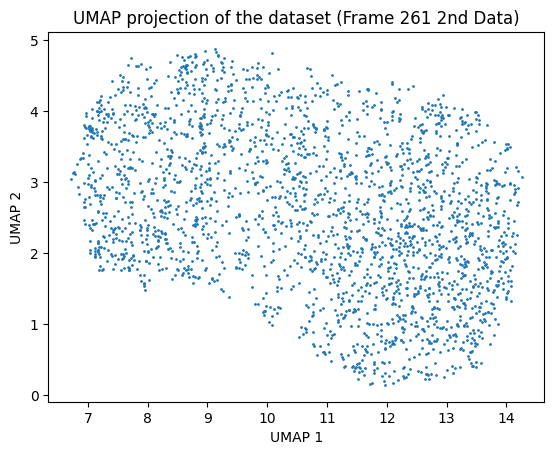

In [4]:
# Visualizing the result
plt.scatter(embedding[:, 0], embedding[:, 1],s=1)
plt.title("UMAP projection of the dataset (Frame 261 2nd Data)")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [5]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(embedding)

# Evaluate the densities on the embedding itself
log_density = kde.score_samples(embedding)
density = np.exp(log_density)

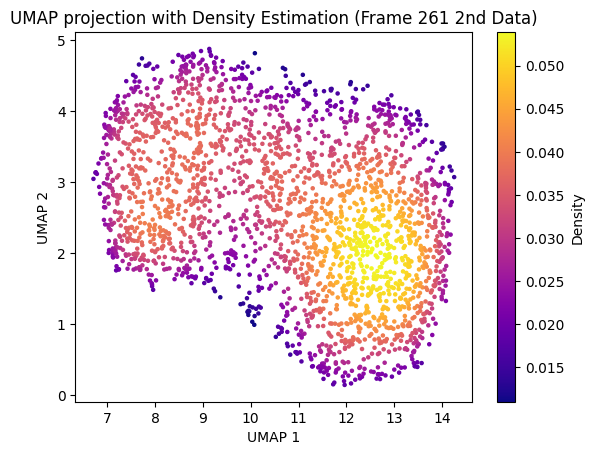

In [6]:
# Create the scatter plot with colors based on density
plt.scatter(embedding[:, 0], embedding[:, 1], c=density, cmap='plasma', s=5)
plt.colorbar(label='Density')
plt.title('UMAP projection with Density Estimation (Frame 261 2nd Data)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [7]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[embedding[:, 0].min():embedding[:, 0].max():1000j, 
                          embedding[:, 1].min():embedding[:, 1].max():1000j]

# Interpolate the density values onto the grid
grid_density = griddata(embedding, density, (grid_x, grid_y), method='cubic')

# Clip any negative values to zero
grid_density = np.clip(grid_density, a_min=0, a_max=None)

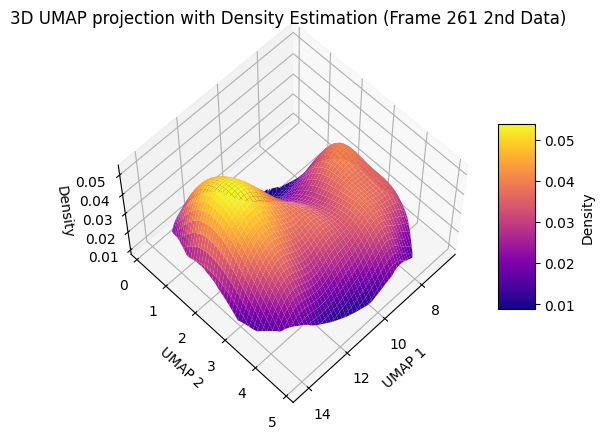

In [8]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the 3D surface plot using a 'viridis' colormap
# We use the interpolated grid_density values as our Z-axis
surf = ax.plot_surface(grid_x, grid_y, grid_density, cmap='plasma', edgecolor='none')

# Add color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Density')

# Set labels and title
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('Density')
plt.title('3D UMAP projection with Density Estimation (Frame 261 2nd Data)')

ax.view_init(elev=60, azim=45)  # elev is the elevation angle, azim is the azimuth angle


# Show plot
plt.show()

c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


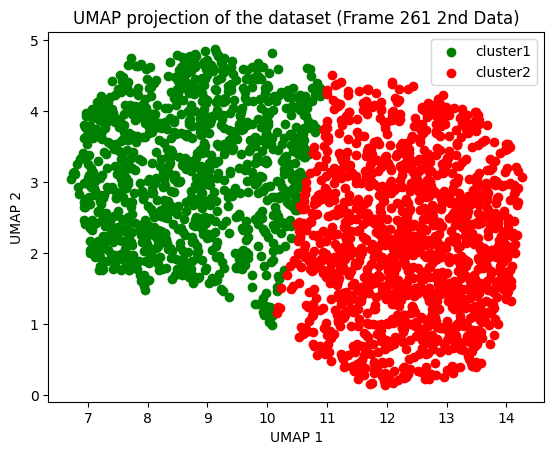

In [11]:
from sklearn.cluster import KMeans
# identifying the most representative or central points within each cluster.
n_cluster = 2
kmeans = KMeans(n_clusters=n_cluster,init='random')
clusters = kmeans.fit_predict(embedding)

colors = ['g','r','b','y']
for i in range(n_cluster):
    cluster_top = embedding[clusters==i]
    plt.scatter(cluster_top[:,0], cluster_top[:,1], color=colors[i], label=f'cluster{i+1}' )

plt.title("UMAP projection of the dataset (Frame 261 2nd Data)")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()
    

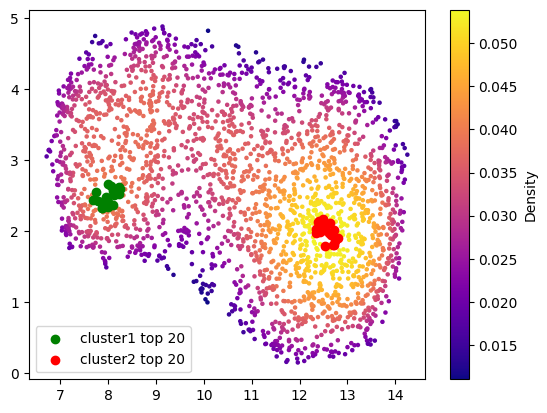

In [15]:
import os

top_points_by_density = {}
n_cluster = 2
N = 20
colors = ['g','r']

plt.scatter(embedding[:, 0], embedding[:, 1], c=density, cmap='plasma', s=5)
plt.colorbar(label='Density')



prefix = 'timelapse_second_dataset_261'
pre = len(prefix)

top_cluster_ids = []
# the top 10 point label
top_index = []
# the top 10 point index for embedding
for i in range(n_cluster):
    # Select data points belonging to the i-th cluster
    cluster_data_indices = np.where(clusters == i)[0]
    cluster_densities = density[cluster_data_indices]

    # Sort the densities within this cluster in descending order and get the top 10
    top_indices = cluster_data_indices[np.argsort(cluster_densities)[::-1][:N]]
    top_index.append(top_indices)

    #plt the top N point
    plt.scatter(embedding[top_indices,0], embedding[top_indices,1], color=colors[i], label=f'cluster{i+1} top {N}')
    plt.legend()
    # Get the actual top points from the embedding
    top_points = embedding[top_indices]
    top_ids = data.iloc[top_indices]['filename']
    extracted_ids = [int(os.path.basename(filename)[pre:].split('.')[0]) for filename in top_ids]

    top_cluster_ids.append(extracted_ids)

# save top_cluster_ids
#df_top_cluster_ids = pd.DataFrame(top_cluster_ids).transpose()

# Naming the columns for clarity
#df_top_cluster_ids.columns = [f'Cluster_{i+1}_Top_IDs' for i in range(n_cluster)]

# Save the DataFrame as a CSV file
#df_top_cluster_ids.to_csv('Mari_2nd_Data_top_cluster_ids_last_Frame_incorect.csv', index=False)

In [13]:
from tifffile import imread

membrane_dir = 'D:/Ziwei/Mari_Second_Dataset_Analysis/seg_membrane_timelapses/timelapse_second_dataset_261.tif'

membrane_seg = imread(membrane_dir)
print(membrane_seg.shape)

raw_dir = 'D:/Ziwei/Mari_Second_Dataset_261_frame/Merged-261.tif'
raw_img = imread(raw_dir)
print(raw_img.shape)
raw_mb = raw_img[:,0,:,:]
raw_nc = raw_img[:,1,:,:]

(17, 2439, 2439)
(17, 2, 2439, 2439)


In [16]:
def cluster_top_label(seg_img, top_cluster_ids, cluster_id):
    '''
    seg_img nd-array
    top_cluster_ids: DataFrame (n,n_clusters)
    cluster_id int
    '''
    cluster_img = np.zeros_like(seg_img)
    for cell_id in top_cluster_ids[cluster_id-1]:
        cluster_img[seg_img == cell_id] = cell_id
        #print(cell_id)
    return cluster_img.astype(int)

cluster_1 = cluster_top_label(membrane_seg,top_cluster_ids,1)
cluster_2 = cluster_top_label(membrane_seg,top_cluster_ids,2)

In [18]:

viwer = napari.Viewer()
viwer.add_image(raw_mb)
viwer.add_labels(cluster_1)
viwer.add_labels(cluster_2)

<Labels layer 'cluster_2' at 0x27133d1d5e0>

In [52]:
threshold = 0.5

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# Assign discrete cluster labels based on the threshold
umap_df['Cluster1_Label'] = np.where(data['cluster1'] > threshold, 'Cluster 1', 'Other')
umap_df['Cluster2_Label'] = np.where(data['cluster2'] > threshold, 'Cluster 2', 'Other')

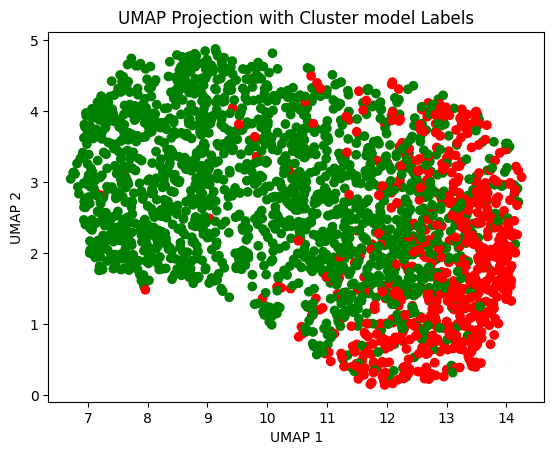

In [14]:
# Define colors for the clusters
cluster_from_model = data['cluster1'].apply(lambda x: 1 if x >= 0.5 else 2)
colors = ['r' if label == 1 else 'g' for label in cluster_from_model]
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)
plt.title('UMAP Projection with Cluster model Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


In [22]:
# all cluster labels in membrane_seg
# k means cluster
all_cluster_ids = []  # This will store IDs of all points in each cluster

# Loop through each cluster
for i in range(n_cluster):
    # Select data points belonging to the i-th cluster
    cluster_data_indices = np.where(clusters == i)[0]
    
    # Get all the IDs for the current cluster
    cluster_ids = data.iloc[cluster_data_indices]['filename']
    extracted_ids = [int(os.path.basename(filename)[pre:].split('.')[0]) for filename in cluster_ids]

    all_cluster_ids.append(extracted_ids)

# Now, all_cluster_ids contains all the IDs for each cluster


In [20]:
# cellshape_cluster
n_cluster = 2  # Update this based on your actual number of clusters

# Initialize a list to store IDs for each cluster
all_cellshape_cluster_ids = []

# Threshold for determining cluster membership
threshold = 0.5

# Determine cluster membership based on threshold
for i in range(n_cluster):
    cluster_name = f'cluster{i+1}'
    # Apply threshold to determine if the data point belongs to this cluster
    cluster_data_indices = data[data[cluster_name] > threshold].index
    # Get the IDs for the current cluster
    cluster_ids = data.iloc[cluster_data_indices]['filename']
    extracted_ids = [int(os.path.basename(filename)[pre:].split('.')[0]) for filename in cluster_ids]
    all_cellshape_cluster_ids.append(extracted_ids)

In [23]:
def cluster_label_vectorized(seg_img, top_cluster_ids, cluster_id):
    '''
    optimized version of cluster_label function using vectorization
    seg_img: nd-array
    top_cluster_ids: list of lists, each sublist contains ids for one cluster
    cluster_id: int
    '''
    # Create a boolean mask where each cell ID in the top_cluster_ids for the given cluster_id is True
    mask = np.isin(seg_img, top_cluster_ids[cluster_id-1])

    # Use this mask to create the cluster image
    cluster_img = np.where(mask, seg_img, 0)

    return cluster_img.astype(int)

# Using the optimized function
cluster_1 = cluster_label_vectorized(membrane_seg, all_cluster_ids, 1)
cluster_2 = cluster_label_vectorized(membrane_seg, all_cluster_ids, 2)

cellshape_cluster_1 = cluster_label_vectorized(membrane_seg,all_cellshape_cluster_ids,1)
cellshape_cluster_2 = cluster_label_vectorized(membrane_seg,all_cellshape_cluster_ids,2)


In [24]:
def clusters_mask_image(seg_img, cluster_ids):
    '''
    seg_img: nd-array
    top_cluster_ids: list of lists, each sublist contains ids for one cluster
    '''
    # Initialize an array of zeros with the same shape as seg_img
    cluster_labeled_img = np.zeros_like(seg_img)

    # Iterate over each cluster
    for i, cluster_id in enumerate(cluster_ids, start=1):
        # Create a mask for the current cluster
        cluster_mask = np.isin(seg_img, cluster_id)
        # Assign the cluster_id to the corresponding pixels
        cluster_labeled_img[cluster_mask] = i

    return cluster_labeled_img

# Using the function
labeled_image = clusters_mask_image(membrane_seg, all_cluster_ids)
cell_shape_labeled_image = clusters_mask_image(membrane_seg, all_cellshape_cluster_ids)


In [26]:

viwer = napari.Viewer()
viwer.add_image(raw_mb)
viwer.add_labels(cluster_1, name='kmeans cluster 1')
viwer.add_labels(cluster_2, name='kmeans cluster 2')
viwer.add_labels(labeled_image, name='kmeas cluster label')
viwer.add_labels(cellshape_cluster_2, name='cellshape cluster 1') # diff to kemans
viwer.add_labels(cellshape_cluster_1, name='cellshape cluster 2') # 
viwer.add_labels(cell_shape_labeled_image, name='cellshape cluster label')


<Labels layer 'cellshape cluster label' at 0x1a5e8007a30>